# Probabilistic weather forecast

This notebook collects data from IBM's probabilistic weather model output, does some statistical plots of weather, and drives a basic weather-damage model.

Comments/queries: james.burn@ibm.com

## Background

As a commercial weather forecasting agency, **The Weather Company, an IBM Business** collect and use the data from *many different* weather models to produce their forecast. These models, like the European ECMWF, American GFS and the IBM GRAF model run independently and use huge computing resource to collect and process observations, and then forecast the weather: https://en.wikipedia.org/wiki/Numerical_weather_prediction.

**IBM Weather Business Solutions** Probabilistic Forecast APIs https://ibm.co/v3FPFP give access to the statistics behind this array of models on a ground-point-location basis. There are 4 ways to query the data:
1. The full, discrete PDF (Probability Distribution Function)
2. Percentiles of the distribution
3. Subset probabilities of the PDF distribution
4. Prototypes

These can be used to give confidence in the standard forecasts - "what is the % chance of temperatures in Oxford exceeding 25C next week?" However with outputs like *Prototypes* it is possible to combine the different forecast weather variables from multiple models to produce forecast confidences of other weather affected variables.

## Prototypes

This offers a way to harness the full power of the meteorological data behind the IBM Weather forecasts:

The API response for a specific location includes the requested quantity of individually unique, but statistically representative hourly forecasts for the specified parameter.  Each of the individual forecasts returned are statistically viable and as a collection they retain the characteristics of the underlying probability distribution for the parameter at each forecast hour.  The underlying probability distribution function is represented with higher resolution the larger the requested quantity of forecasts. A user may utilize a collection of prototype forecasts to provide multiple variable inputs to a downstream model to obtain a meaningful distribution of outcomes from that model.

## Applying probabilistic weather data to an existing predictive model  

Let's have a look at some probabilistic weather data. Then feed the data into a predictive model to look at confidence in the outcome! 


Set up some packages for the Python code

In [ ]:
import json
import pandas as pd
import requests
import math
%matplotlib inline
import matplotlib.pyplot as plt

The API documentation link above contains the full list of parameters. 
The probabilistic forecast API can be called globally every 0.01 degree latitude/longitude. This equates to approximately a 1km grid.
The response gives hourly forecasts, up to 360 hours from "now".

Set some basic parameters for the API call.

You can set the number of *Prototypes* to be received - in this case we'll start with 20. 
This returns the hourly data for 20 distinct forecasts and we will look at these.


In [ ]:
lat='40.71'
lon='-74.00' #NY

lat='64.14'
lon='-21.94'  #Reykjavík
lat='51.47'
lon='-0.45' #Heathrow
lat='50.43'
lon='5.97'  #Spa, Belgium
lat='25.7'
lon='-80.1' #Miaimi
lat='51.75'
lon='-1.25' #oxford!

#elevation='50'
parameter_string='windSpeed:20'
#or try
#parameter_string='temperature:20'

Beyond development, it is recommmended to embed the API key in a secure folder, or if using Watson Studio secure via access control, not put in the script!

In [ ]:
APIKEY="THE_WEATHER_COMPANY_DATA_PACKAGE_KEY_HERE"

This cell above defines APIKEY.
This key above will expire 4th September 2020. 


Set the other request components:

In [ ]:
base1 = 'https://api.weather.com/v3/wx/forecast/probabilistic?geocode='
base2 = lat+","+lon
base3 = '&format=json&units=m'#&elevation='+elevation
base4='&landuse=1&prototypes='+parameter_string
base5='&apiKey='+APIKEY
url = base1 + base2 + base3 + base4 + base5# make API URL   #
print (url)

Make the request:

In [ ]:
req=requests.get(url)
json_data = json.loads(req.text)
    

Put the JSON response time data into a Pandas dataframe, converting from UNIX time format to something more readable.

In [ ]:
time = pd.DataFrame.from_dict(json_data['forecasts1Hour']['fcstValid'])
time[0] = pd.to_datetime(time[0],unit='s')
time.head()

Put the different variable forecasts into a dataframe. The variable is defined in the parameter_string='**variablename**:20' requested in the API call

In [ ]:
df = pd.DataFrame.from_dict(json_data['forecasts1Hour']['prototypes'])
df2 = pd.DataFrame.from_dict(df.forecast[0])
wxvar = df2.transpose()
wxvar.head()

Have a quick look at the data

In [ ]:
import seaborn as sns; sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (34,14)

plt.style.use('bmh')
plt.plot(wxvar)

plt.show()

In [ ]:
#add in some more stats

plt.plot(wxvar)

#SD
DamStd=wxvar.std(axis=1)
plt.plot(DamStd,linewidth=5.0)

#Mean
DamMean=wxvar.mean(axis=1)
plt.plot(DamMean,linewidth=5.0)

plt.show()

In [ ]:
#add the time data to the wxvar dataframe
wxvar['time']=time

In [ ]:
#let's try and box and whiskers plot
wxvar2 = pd.melt(wxvar, ['time'])
#wxvar2['variable']=wxvar2['variable'].astype(float)

ax = sns.boxplot(x='time', y='value', data=wxvar2)


In [ ]:
#thin out the data a bit - every 3 hours
import numpy as np
wxvar3 = wxvar.iloc[::3, :]
#wxvar3.drop(['time'],axis=1,inplace=True)

wxvar3.head()

In [ ]:
#wxvar3
#let's try and box and whiskers plot
wxvar3 = pd.melt(wxvar3, ['time'])
#wxvar3['variable']=wxvar3['variable'].astype(float)
plt.figure(figsize=(28,10))  #makes wider

from matplotlib.dates import DateFormatter
#ax.set_xticklabels(labels=x_dates, rotation=45)
ax = sns.boxplot(x='time', y='value', data=wxvar3, palette='terrain')

ax.grid(True)
# Define the date format
#doesn't work ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.xticks(rotation=270)

#overlay actuals
#bplot=sns.swarmplot(y='value', x='time',
 #             data=wxvar3, 
  #            color='black',
   #           alpha=0.5)


So, there's some prototype weather data. Notice the general spreading trend as the models diverge in time. If there is convergence of models in the future this indicates an increased confidence in the forecast. Let's do some more analysis. 

## Wind damage modelling
For this demonstration we're going to introduce a very basic wind-damage model. Based on a hypothetical exponential S-curve fit with some wind-speed data from: https://www.sciencedirect.com/science/article/pii/S187770581830064X  This convert wind-speed into a "Damage ratio" from 0-100. 

It is triggered when the wind-speed reaches a certain threshold and outputs damage based on basic mathematical function.

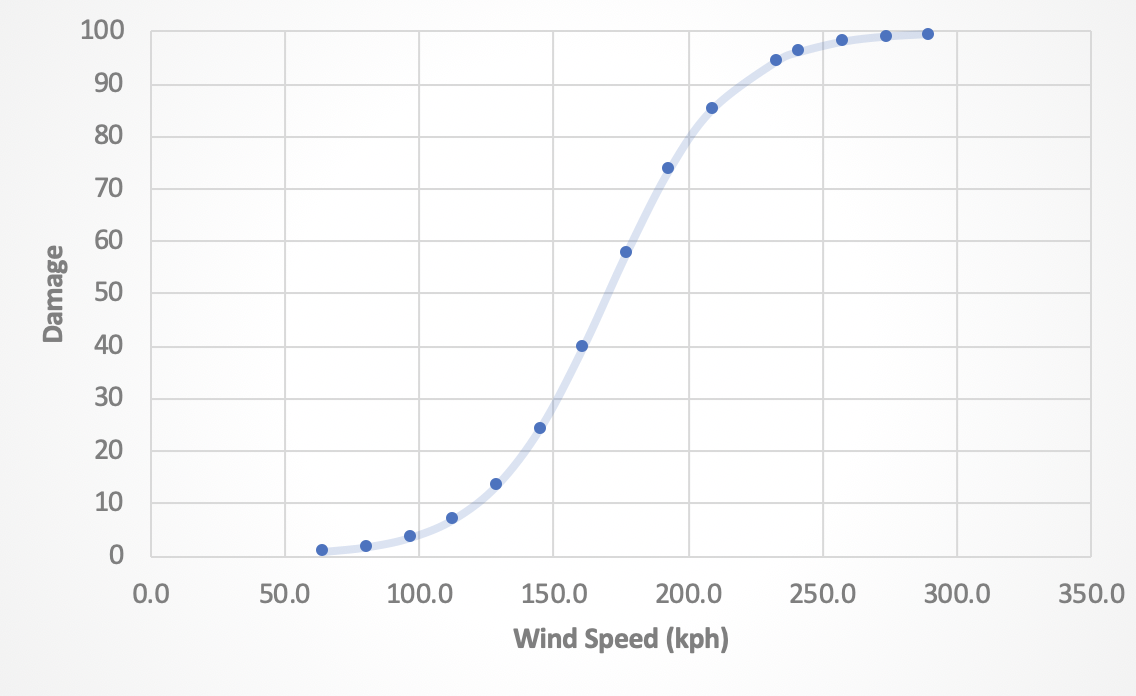


In [ ]:
def DemoModel(windspeed):
#basic model to convert windspeed (in m/s) into damage (rated from 0-100) 
#Damage doesn't start until 67kph, then exponential S-curve increase to 260kph     
    x=windspeed * 3.6 #convert m/s to kph

    if x<=67:
        dam = 0

    if x>67 and x<260:
#        dam = (0.6*x)- 40
        dam =100/(1+math.exp(-0.045*(x-170)))
    elif x >=260:
        dam = 100

    return dam

In [ ]:
DemoModel(50)

In [ ]:
#test model for different speeds
rows = []
for x in range(0, 80, 2):
    rows.append([x,  x*3.6, DemoModel(x)])

dfWModel = pd.DataFrame(rows, columns=["WindSp m/s", "Wind kph","Damage"])    
print(dfWModel)
#dfWModel.plot()

Let's make a model for a "house made of staw" (which be be more easily damaged/destroyed by wind!)

In [ ]:
def DemoModelTest(windspeed):
#change threshold to generate damage at much lower winds (perhaps for a house made of straw)  
    x=windspeed * 3.6

    if x<=5:
        dam = 0

    if x>5 and x<70:
#        dam = (0.6*x)- 40
        dam =100/(1+math.exp(-0.15*(x-35)))
    elif x >=70:
        dam = 100

    return dam


In [ ]:
#test model for different speeds
rows = []
for x in range(0, 21, 1):
    rows.append([x,  x*3.6, DemoModelTest(x)])

dfWModel = pd.DataFrame(rows, columns=["WindSp m/s", "Wind kph","Damage"])    
print(dfWModel)

Apply the model to each of the wind speed elements in the dataframe:

In [ ]:
#Check our weather dataframe again.
wxvar.head()

In [ ]:
#take out time column and apply damage model
Dam=wxvar.iloc[:, 0:20].applymap(DemoModelTest)

In [ ]:
#Have a look at the output
Dam.plot()

In [ ]:
DamMean=Dam.mean(axis=1)
DamMean.plot()

In [ ]:
DamStd=Dam.std(axis=1)
DamStd.plot()

In [ ]:
Dam['time']=time
DamTime = pd.melt(Dam, ['time'])
Dam.head()

In [ ]:
#Dam['variable']=Dam['variable'].astype(float)
plt.figure(figsize=(28,10))  #makes wider

#from matplotlib.dates import DateFormatter
Dam = pd.melt(Dam, ['time'])
#ax.set_xticklabels(labels=x_dates, rotation=45)
ax = sns.boxplot(x='time', y='value', data=Dam, palette='terrain')

ax.grid(True)
# Define the date format
#doesn't work ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
plt.xticks(rotation=270)


In [ ]:
Dam2 = Dam.iloc[::3, :]
Dam2 = pd.melt(Dam2, ['time'])
#wxvar2['variable']=wxvar2['variable'].astype(float)
Dam2.head()

In [ ]:
#ax = sns.boxplot(x='time', y='value', data=Dam2)